In [104]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

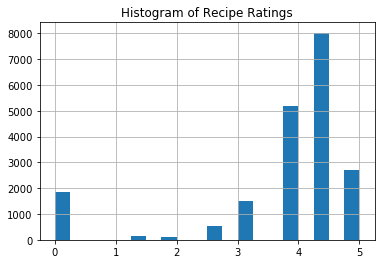

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [7]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

In [8]:
plt.scatter(Y, svr.predict(X))

KeyboardInterrupt: 

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [9]:
svr.score(X, Y)

0.038565706512988962

In [10]:

cross_val_score(svr, X, Y, cv=5)

array([ 0.01818511,  0.026411  ,  0.03037705,  0.01957949,  0.02451197])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

In [11]:
X.shape

(20052, 674)

In [12]:
X.head()

,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Maybe we first can exclude uncommon ingredients to reduce dimensionality. Let's just grab the 50 most common ingredients.

In [29]:
X.sum(axis=0).sort_values(ascending=False)[50]

1087.0

In [36]:
top_50 = X.sum(axis=0).sort_values(ascending=False).index[:50]
top_50

Index(['bon appétit', 'peanut free', 'soy free', 'tree nut free', 'vegetarian',
       'gourmet', 'kosher', 'pescatarian', 'quick & easy', 'wheat/gluten-free',
       'bake', 'summer', 'dessert', 'dairy free', 'side', 'no sugar added',
       'winter', 'fall', 'dinner', 'sugar conscious', 'healthy',
       'kidney friendly', 'onion', 'tomato', 'vegetable', 'sauté',
       'milk/cream', 'fruit', 'vegan', 'kid-friendly', 'egg', 'spring', 'herb',
       'garlic', 'salad', 'dairy', 'thanksgiving', 'appetizer', 'lunch',
       'cheese', 'chicken', 'roast', 'no-cook', 'soup/stew', 'cocktail party',
       'ginger', 'potato', 'chill', 'lemon', 'grill/barbecue'],
      dtype='object')

Okay, most of those aren't actually ingredients, but let's see how it works. 

In [40]:
X[top_50].head()

,bon appétit,peanut free,soy free,tree nut free,vegetarian,gourmet,kosher,pescatarian,quick & easy,wheat/gluten-free,...,chicken,roast,no-cook,soup/stew,cocktail party,ginger,potato,chill,lemon,grill/barbecue
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
svr.fit(X[top_50],Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
svr.score(X[top_50], Y)

0.004155284085605504

(array([  963.,   697.,   293.,   136.,   463.,  1383.,  4994.,  8005.,
         2813.,   305.]),
 array([-4.55565363, -3.91625577, -3.27685791, -2.63746005, -1.99806219,
        -1.35866433, -0.71926647, -0.07986861,  0.55952925,  1.19892711,
         1.83832497]),
 <a list of 10 Patch objects>)

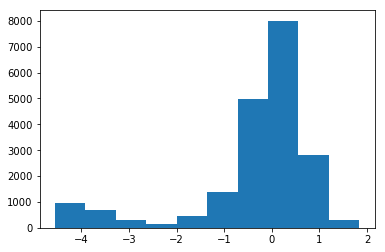

In [46]:
plt.hist((Y - svr.predict(X[top_50])))

I'm curious why our score is .004 when the residuals are actually fairly close to zero on this -- is it because it's SVM instead of linear regression? It seems like it's doing an okay job fitting the data...

Anyway -- now on to trying it out as a binary classifier.

In [48]:
Y.value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

There is something going wrong with this rating data -- Epicurious rates their dishes on a "4-fork" scale, and recipes with zero reviews are the only ones with zero forks. Increments are 1/2 a fork at a time. So what's actually going on here is:

    0.000: no data
    1.250: 1 fork
    1.875: 1.5 forks
    2.500: 2 forks
    3.125: 2.5 forks
    3.750: 3 forks
    4.375: 3.5 forks
    5.000: 4 forks
    
Which means that our regression didn't have a chance with all that bad data, and the weird spacing between classes. We'll get to binary classification, but I'm curious if a well-structured regression would work any better. Let's multiply the "Forks" by two so we're looking at integers, and get rid of all the zeros.

In [61]:
np.where(Y==0)

(array([   25,    36,    42, ..., 20008, 20019, 20037]),)

In [75]:
X = X[Y!=0]
Y = Y[Y!=0]

In [82]:
Y[Y==5] = 8
Y[Y==4.375] = 7
Y[Y==3.75] = 6
Y[Y==3.125] = 5
Y[Y==2.5] = 4
Y[Y==1.875] = 3
Y[Y==1.25] = 2

In [83]:
Y.value_counts()

7.0    8019
6.0    5169
8.0    2719
5.0    1489
4.0     532
2.0     164
3.0     124
Name: rating, dtype: int64

In [84]:
svr.fit(X[top_50],Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [85]:
svr.score(X[top_50], Y)

-0.028348052282807679

(array([  159.,    83.,    48.,   511.,  1148.,   691.,  4744.,  7575.,
         2240.,  1017.]),
 array([-5.14951253, -4.45394848, -3.75838443, -3.06282038, -2.36725633,
        -1.67169228, -0.97612824, -0.28056419,  0.41499986,  1.11056391,
         1.80612796]),
 <a list of 10 Patch objects>)

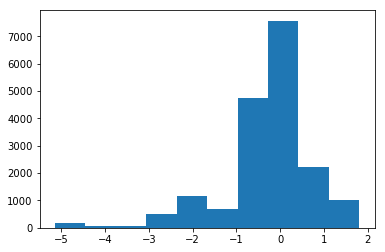

In [86]:
plt.hist((Y - svr.predict(X[top_50])))

This looks pretty good -- almost all the predictions are within one rating number. I think I'm confused about why the score is coming out so badly. But now actually on to binary classification! We can separate our rankings into "good" and "bad", but it's hard to choose where to put the boundary line. A natural threshold, I think, would be at 5.5 on our scale from 2 to 8 (this means 2.5 or fewer forks would be "bad", 3, 3.5, and 4 forks would be "good"). This leaves us with skewed classes -- the vast majority of recipes would be "good". 

(array([  164.,   124.,   532.,  1489.,  5169.,  8019.,  2719.]),
 array([ 2.        ,  2.85714286,  3.71428571,  4.57142857,  5.42857143,
         6.28571429,  7.14285714,  8.        ]),
 <a list of 7 Patch objects>)

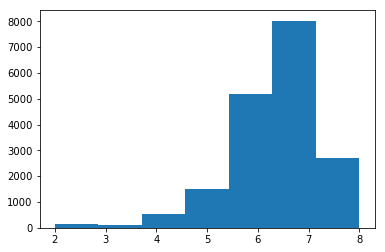

In [89]:
plt.hist(Y, 7)

In [92]:
(Y>5.5).sum()

15907

So another option would be to set the threshold at 6.5, so that only the 3.5 and 4 fork recipes make the cut. This is probably closer to how I would use their website -- only choose the best recipes. Let's see how it works.

In [93]:
Y_bin = np.where(Y>6.5, 1, 0)

In [98]:
from sklearn.svm import SVC
svc = SVC()

In [99]:
svc.fit(X[top_50],Y_bin)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [102]:
svc.score(X[top_50],Y_bin)

0.59041501976284583

A number that makes sense! Yay!

In [105]:
cross_val_score(svc, X[top_50], Y_bin, cv=5)

array([ 0.59001098,  0.58973655,  0.58973655,  0.58923668,  0.58978583])

Didn't even overfit! But we could try for better accuracy... I wonder if reducing the number of features made a big difference, or if that is due to ambiguity in the dataset. Even though we're supposed to reduce down to 30 features, let's see what happens if we bump up to the 100 most common features.

In [106]:
top_100 = X.sum(axis=0).sort_values(ascending=False).index[:100]
top_100

Index(['bon appétit', 'peanut free', 'soy free', 'tree nut free', 'vegetarian',
       'gourmet', 'kosher', 'pescatarian', 'quick & easy', 'wheat/gluten-free',
       'bake', 'summer', 'dessert', 'no sugar added', 'dairy free', 'winter',
       'side', 'fall', 'dinner', 'sugar conscious', 'healthy', 'onion',
       'kidney friendly', 'tomato', 'vegetable', 'sauté', 'milk/cream',
       'fruit', 'egg', 'vegan', 'spring', 'herb', 'kid-friendly', 'garlic',
       'salad', 'dairy', 'thanksgiving', 'cheese', 'appetizer', 'chicken',
       'roast', 'lunch', 'no-cook', 'soup/stew', 'potato', 'ginger', 'chill',
       'grill/barbecue', 'low cal', 'lemon', 'high fiber', 'christmas',
       'pasta', 'food processor', 'sauce', 'pork', 'fish', 'backyard bbq',
       'leafy green', 'low fat', 'nut', 'cocktail party', 'condiment/spread',
       'citrus', 'simmer', 'mushroom', 'chocolate', 'beef', 'brunch', 'party',
       'bell pepper', 'orange', 'paleo', 'cake', 'breakfast', 'carrot',
       'spice

We got Bacon and Chocolate back! 

In [107]:
cross_val_score(svc, X[top_100], Y_bin, cv=5)

array([ 0.59165752,  0.60016465,  0.59687157,  0.60021966,  0.59308072])

Okay, so that's pretty much exactly the same. Let's try it with just the 30 most common features and see what happens.

In [108]:
top_30 = X.sum(axis=0).sort_values(ascending=False).index[:30]
top_30

Index(['bon appétit', 'peanut free', 'soy free', 'tree nut free', 'vegetarian',
       'gourmet', 'kosher', 'pescatarian', 'quick & easy', 'wheat/gluten-free',
       'bake', 'summer', 'dessert', 'no sugar added', 'dairy free', 'winter',
       'side', 'fall', 'dinner', 'sugar conscious', 'healthy', 'onion',
       'kidney friendly', 'tomato', 'vegetable', 'sauté', 'milk/cream',
       'fruit', 'egg', 'vegan'],
      dtype='object')

In [109]:
cross_val_score(svc, X[top_30], Y_bin, cv=5)

array([ 0.58781559,  0.5902854 ,  0.59055982,  0.592257  ,  0.59170785])

That did just about as well and the top 100 features, so we could stop there. And we've used the 30 features that supposedly have the most information -- but what we're really interested in is the difference between "good" and "bad" recipes. So what if we look at the 30 features that are the *most different* between those two groups?

In [141]:
controversial_30 = ((X[Y_bin==0].mean(axis=0) - X[Y_bin==1].mean(axis=0)) ** 2).sort_values(ascending=False).index[:30]
controversial_30

Index(['bon appétit', 'gourmet', 'quick & easy', 'soy free', 'peanut free',
       'dinner', 'vegetable', 'thanksgiving', 'pasta', 'vegetarian', 'side',
       'roast', 'dessert', 'low fat', 'christmas', 'sauté', 'tree nut free',
       'grill/barbecue', 'vegan', 'backyard bbq', 'fall', 'chicken', 'grill',
       'no-cook', 'lunch', 'potato', 'stir-fry', 'bell pepper', 'fruit',
       'kidney friendly'],
      dtype='object')

In [142]:
cross_val_score(svc, X[controversial_30], Y_bin, cv=5)

array([ 0.59687157,  0.59824369,  0.60318332,  0.60433828,  0.59829764])

So, only a tiny improvement over using the 30 most frequent tags. Let's do one run with the 100 most controversial features.

In [143]:
controversial_100 = ((X[Y_bin==0].mean(axis=0) - X[Y_bin==1].mean(axis=0)) ** 2).sort_values(ascending=False).index[:100]
controversial_100

Index(['bon appétit', 'gourmet', 'quick & easy', 'soy free', 'peanut free',
       'dinner', 'vegetable', 'thanksgiving', 'pasta', 'vegetarian', 'side',
       'roast', 'dessert', 'low fat', 'christmas', 'sauté', 'tree nut free',
       'grill/barbecue', 'vegan', 'backyard bbq', 'fall', 'chicken', 'grill',
       'no-cook', 'lunch', 'potato', 'stir-fry', 'bell pepper', 'fruit',
       'kidney friendly', 'turkey', 'bread', 'winter', 'yogurt', 'dairy free',
       'cranberry', 'rice', 'almond', 'spring', 'pescatarian', 'party',
       'zucchini', 'kid-friendly', 'fourth of july', 'goat cheese',
       'christmas eve', 'cabbage', 'cornmeal', 'low/no sugar', 'cake', 'berry',
       'drink', 'low cholesterol', 'father's day', 'sausage', 'paleo',
       'no sugar added', 'poultry', 'chile pepper', 'high fiber', 'meat',
       'lamb', 'broccoli', 'red wine', 'rosemary', 'summer',
       'condiment/spread', 'alcoholic', 'stuffing/dressing', 'low carb',
       'family reunion', 'pea', 'walnut',

In [144]:
cross_val_score(svc, X[controversial_100], Y_bin, cv=5)

array([ 0.59385291,  0.60043908,  0.60400659,  0.60104338,  0.59555189])

Still the same... let's see how we're getting things wrong. I'm a little nervous that the accuracy is about equal to the proportion of positive to negative reviews.

In [145]:
from sklearn.metrics import confusion_matrix

In [146]:
svc.fit(X[controversial_30], Y_bin)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [147]:
Y_pred = svc.predict(X[controversial_30])

In [149]:
confusion_matrix(Y_bin, Y_pred)

array([[  986,  6492],
       [  715, 10023]])

Ah - I was worried this might be happening. Our classifier just predicts "good" for pretty much everything. Maybe we can adjust our SVC parameters to fit better.

In [151]:
sum(Y_bin==1)/len(Y)

0.58948177426438297

In [169]:
svc = SVC(C=1e3)
svc.fit(X[controversial_30], Y_bin)
Y_pred = svc.predict(X[controversial_30])
print(svc.score(X[controversial_30], Y_bin))
print(confusion_matrix(Y_bin, Y_pred))

0.672375933245
[[2580 4898]
 [1070 9668]]


In [170]:
cross_val_score(svc, X[controversial_30], Y_bin, cv=5)

array([ 0.59357849,  0.60510428,  0.60016465,  0.60241625,  0.59939594])

I played around with the C value to no avail -- lower values lead to all positive predictions. So any improvement in score with a high penalty parameter C is just due to overfitting. So basically SVC is only working to bring accuracy up 1% over simply voting "all good". That's pretty disappointing. Sanity check using a different classifier.

In [172]:
from sklearn.ensemble import RandomForestClassifier

In [173]:
rfc = RandomForestClassifier()

In [176]:
rfc.fit(X[controversial_30], Y_bin)
Y_pred = rfc.predict(X[controversial_30])
print(svc.score(X[controversial_30], Y_bin))
print(confusion_matrix(Y_bin, Y_pred))

0.672375933245
[[4055 3423]
 [1411 9327]]


In [175]:
cross_val_score(rfc, X[controversial_30], Y_bin, cv=5)

array([ 0.58863886,  0.5949506 ,  0.59330406,  0.59610104,  0.57880286])

In [177]:
cross_val_score(rfc, X[controversial_100], Y_bin, cv=5)

array([ 0.60428101,  0.62294182,  0.60812294,  0.59692477,  0.61779242])

In [178]:
cross_val_score(rfc, X[top_100], Y_bin, cv=5)

array([ 0.61306257,  0.60126235,  0.60839737,  0.61147721,  0.61779242])

In [179]:
cross_val_score(rfc, X, Y_bin, cv=5)

array([ 0.6111416 ,  0.61717892,  0.62211855,  0.63179572,  0.63152114])

Well, we're doing barely better here. What if there just isn't much predictive power in the ingredients of a recipe?

In [180]:
from sklearn.ensemble import RandomForestRegressor

In [181]:
rfr = RandomForestRegressor()

In [182]:
rfr.fit(X[controversial_30], Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [183]:
rfr.score(X[controversial_30], Y)

0.2972064722702622

(array([   84.,    57.,   219.,   441.,  1457.,  6483.,  7409.,  1940.,
          115.,    11.]),
 array([-5.09985431, -4.23903555, -3.37821678, -2.51739802, -1.65657925,
        -0.79576049,  0.06505828,  0.92587704,  1.7866958 ,  2.64751457,
         3.50833333]),
 <a list of 10 Patch objects>)

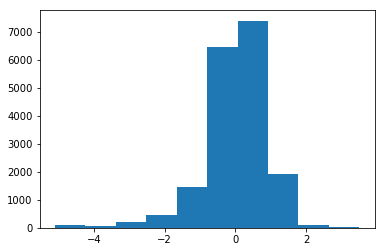

In [184]:
Y_pred = rfr.predict(X[controversial_30])
plt.hist((Y - Y_pred))